In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score
import shap
import matplotlib.pyplot as plt

c:\10x AIMastery\Insurance-risk-analytics\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
df = pd.read_csv(r"C:\10x AIMastery\Insurance-risk-analytics\SM\data\insurance_with_claims.csv")


In [3]:
# Feature Engineering
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 50, 100], labels=['young', 'middle', 'senior'])
df['bmi_category'] = pd.cut(df['bmi'], bins=[0, 25, 30, 100], labels=['normal', 'overweight', 'obese'])
df['smoker_region'] = df['smoker'] + '_' + df['region']

In [4]:
# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['sex', 'smoker', 'region', 'age_group', 'bmi_category', 'smoker_region'], drop_first=True)

In [5]:
# Claim Severity Model (TotalClaims > 0)
claims_data = df_encoded[df_encoded['TotalClaims'] > 0]
X_severity = claims_data.drop(['TotalClaims', 'charges'], axis=1)
y_severity = claims_data['TotalClaims']
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_severity, y_severity, test_size=0.2, random_state=42)

In [6]:
# Premium Model
X_premium = df_encoded.drop(['TotalClaims', 'charges'], axis=1)
y_premium = df_encoded['charges']
X_train_p, X_test_p, y_train_p, y_test_p = train_test_split(X_premium, y_premium, test_size=0.2, random_state=42)

In [7]:
# Claim Probability Model
df_encoded['has_claim'] = (df_encoded['TotalClaims'] > 0).astype(int)
X_prob = df_encoded.drop(['TotalClaims', 'charges', 'has_claim'], axis=1)
y_prob = df_encoded['has_claim']
X_train_prob, X_test_prob, y_train_prob, y_test_prob = train_test_split(X_prob, y_prob, test_size=0.2, random_state=42)

In [8]:
# Models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42)
}
classifiers = {
    'Random Forest Classifier': RandomForestClassifier(random_state=42),
    'XGBoost Classifier': XGBClassifier(random_state=42)
}


In [10]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Evaluate Regression Models
results = {
    'Model': [], 
    'RMSE (Severity)': [], 
    'R2 (Severity)': [], 
    'RMSE (Premium)': [], 
    'R2 (Premium)': []
}

for name, model in models.items():
    try:
        # Severity
        model.fit(X_train_s, y_train_s)
        y_pred_s = model.predict(X_test_s)
        rmse_s = np.sqrt(mean_squared_error(y_test_s, y_pred_s))  # Calculate RMSE manually
        r2_s = r2_score(y_test_s, y_pred_s)
        
        # Premium
        model.fit(X_train_p, y_train_p)
        y_pred_p = model.predict(X_test_p)
        rmse_p = np.sqrt(mean_squared_error(y_test_p, y_pred_p))  # Calculate RMSE manually
        r2_p = r2_score(y_test_p, y_pred_p)
        
        results['Model'].append(name)
        results['RMSE (Severity)'].append(rmse_s)
        results['R2 (Severity)'].append(r2_s)
        results['RMSE (Premium)'].append(rmse_p)
        results['R2 (Premium)'].append(r2_p)
        
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue

# Convert results to DataFrame for better visualization
results_df = pd.DataFrame(results)

In [11]:
# Evaluate Classification Models
class_results = {'Model': [], 'Accuracy': [], 'Precision': [], 'Recall': [], 'F1': []}
for name, clf in classifiers.items():
    clf.fit(X_train_prob, y_train_prob)
    y_pred_prob = clf.predict(X_test_prob)
    class_results['Model'].append(name)
    class_results['Accuracy'].append(accuracy_score(y_test_prob, y_pred_prob))
    class_results['Precision'].append(precision_score(y_test_prob, y_pred_prob))
    class_results['Recall'].append(recall_score(y_test_prob, y_pred_prob))
    class_results['F1'].append(f1_score(y_test_prob, y_pred_prob))

In [12]:
# Print results
print("\nRegression Results:")
print(pd.DataFrame(results))
print("\nClassification Results:")
print(pd.DataFrame(class_results))


Regression Results:
               Model  RMSE (Severity)  R2 (Severity)  RMSE (Premium)  \
0  Linear Regression       686.956720       0.684463     5762.359887   
1      Random Forest       630.498001       0.734197     4565.353796   
2            XGBoost       689.506935       0.682115     4706.564900   

   R2 (Premium)  
0      0.786119  
1      0.865748  
2      0.857314  

Classification Results:
                      Model  Accuracy  Precision    Recall        F1
0  Random Forest Classifier  0.958955   1.000000  0.830769  0.907563
1        XGBoost Classifier  0.951493   0.964286  0.830769  0.892562


age                            float64
bmi                            float64
children                       float64
sex_male                       float64
smoker_yes                     float64
region_northwest               float64
region_southeast               float64
region_southwest               float64
age_group_middle               float64
age_group_senior               float64
bmi_category_overweight        float64
bmi_category_obese             float64
smoker_region_no_northwest     float64
smoker_region_no_southeast     float64
smoker_region_no_southwest     float64
smoker_region_yes_northeast    float64
smoker_region_yes_northwest    float64
smoker_region_yes_southeast    float64
smoker_region_yes_southwest    float64
dtype: object


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\10x AIMastery\\Insurance-risk-analytics\\figures\\shap_summary_premium.png'

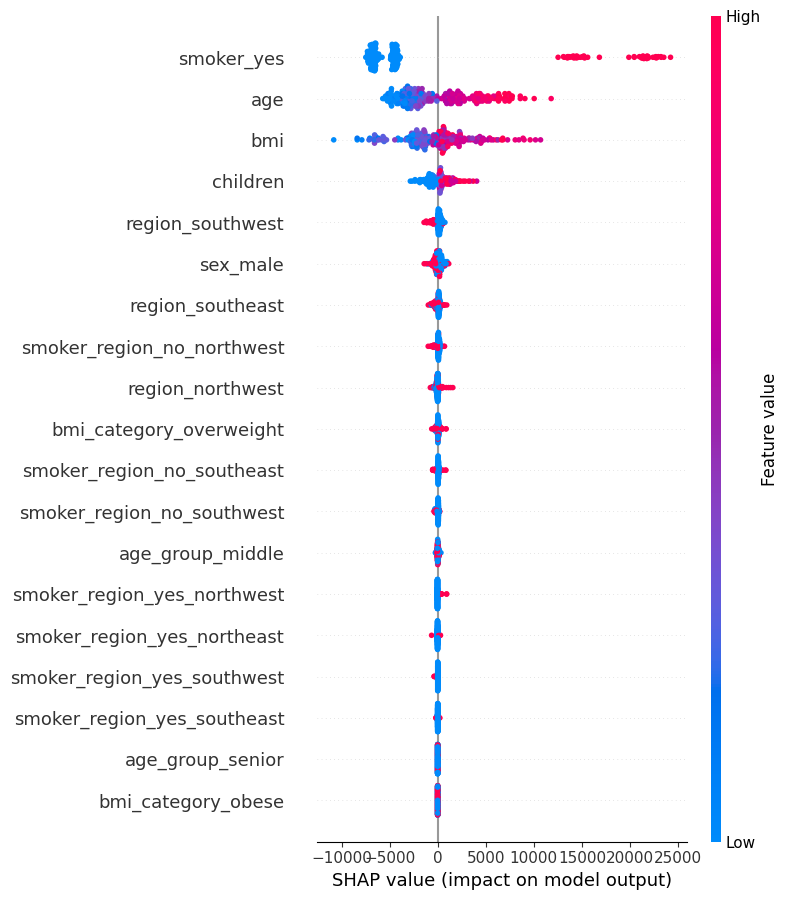

In [15]:
print(X_train_p.dtypes)

# For categorical columns (if any exist)
X_train_p = pd.get_dummies(X_train_p, drop_first=True)
X_test_p = pd.get_dummies(X_test_p, drop_first=True)

# Ensure all data is float
X_train_p = X_train_p.astype(float)
X_test_p = X_test_p.astype(float)

# SHAP Analysis (for best model, e.g., XGBoost)
xgb = XGBRegressor(random_state=42).fit(X_train_p, y_train_p)

explainer = shap.Explainer(xgb, X_train_p)
shap_values = explainer(X_test_p)
shap.summary_plot(shap_values, X_test_p, show=False)
plt.savefig(r"C:\10x AIMastery\Insurance-risk-analytics\figures\shap_summary_premium.png")
plt.close()

In [ ]:
# Save results
pd.DataFrame(results).to_csv('results/model_results.csv', index=False)
pd.DataFrame(class_results).to_csv('results/classification_results.csv', index=False)